In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv("../data/code-review-dataset-clear.csv")

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df["message"], df["is_toxic"],
    test_size=0.2, random_state=42, stratify=df["is_toxic"]
)

In [25]:
is_toxic = len(df[df["is_toxic"] == 1])
not_toxic = len(df[df["is_toxic"] == 0])
print(f"{is_toxic=}, {not_toxic=}, {round(is_toxic/not_toxic, 2)=}")

is_toxic=2522, not_toxic=10381, round(is_toxic/not_toxic, 2)=0.24


In [26]:
model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        stop_words="english",
    )),
    ("logreg", LogisticRegression(
        solver="liblinear",
        penalty="l2",
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ))
])

In [ ]:
model.fit(X_train, y_train)

In [28]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [29]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8938395970554048
ROC-AUC: 0.9253998823088857

Classification report:
               precision    recall  f1-score   support

           0     0.9496    0.9167    0.9329      2077
           1     0.6997    0.7996    0.7463       504

    accuracy                         0.8938      2581
   macro avg     0.8246    0.8582    0.8396      2581
weighted avg     0.9008    0.8938    0.8964      2581



# k-fold

In [30]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

cv_res = cross_validate(model, df["message"], df["is_toxic"], cv=cv, scoring=scoring, n_jobs=-1)
print("CV metrics (mean ± std):")
for k, v in scoring.items():
    s = cv_res[f"test_{k}"]
    print(f"{k:>9}: {np.mean(s):.4f} ± {np.std(s):.4f}")


CV metrics (mean ± std):
 accuracy: 0.8924 ± 0.0090
precision: 0.6990 ± 0.0249
   recall: 0.7918 ± 0.0273
       f1: 0.7421 ± 0.0203
  roc_auc: 0.9297 ± 0.0084


# Confusion matrix

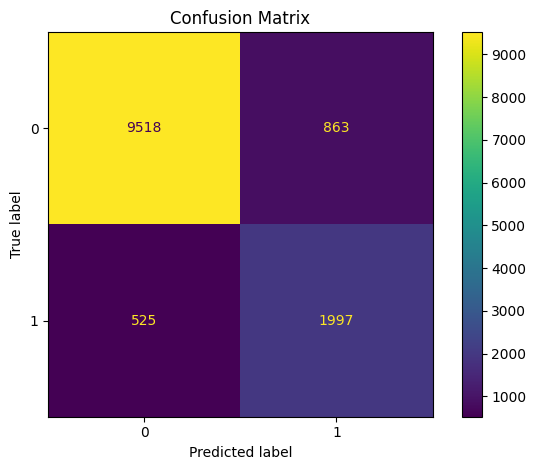

In [31]:
y_pred_oof = cross_val_predict(model, df["message"], df["is_toxic"], cv=cv, n_jobs=-1)

cm = confusion_matrix(df["is_toxic"], y_pred_oof, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()